# Notebook on Model Testing

By Dane Morgan with a lot of materials taken from others

*   Data organized Ryan Jacobs and taken from PLOTTER 22 databaset by Mark Kirk. Please DO NOT SHARE THIS DATA outside of class.  Thank you.
* The data is described below.
* Paper doing a similar fitting can be found here:  https://www.mdpi.com/2075-4701/12/2/186

Learning goal(s):
* Be able to efficiently and correcltly explore accuracy of different model approaches.

Usage Notes
* When you get the the "Load MASTML and its dependencies" section this crashes. To fix this, under the "Runtime" memu, first "Restart runtime" and then "Run all".

# Colab setup

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Set some key global variables for the run.

In [1]:

# Here, modify the path where you saved this notebook and the associated lab files on your Google drive,
# if different from below (this is an example Dane Morgan had for class)
#path = '/content/drive/MyDrive/Colab Stuff/MSE_803_Lab4_Dev_23/'
#path = '/content/drive/MyDrive/Online Filed/Dane Morgan Mixed Sharing/Projects/Courses/MSE803 F22/Modules/Module 4_ML Methods/Lab/'
# Figure sizes
fig_w=6
fig_h=4
# Random number seed
seed=42

Check the path name is assigned correctly.

In [2]:
#!echo $path
#import os
#os.path.isdir(path)


In [3]:
# This is needed so can import packages from a different path than standard libraries
#import sys
#sys.path.append(path)

In [4]:
# Load MASTML and its dependencies
#!pip install mastml
#!pip install pyyaml
#!pip install mastml==3.1.5
#!pip install pyyaml==5.4.1

# Import some MASTML modules
from mastml.mastml import Mastml
from mastml.datasets import LocalDatasets
from mastml.data_cleaning import DataCleaning
from mastml.preprocessing import SklearnPreprocessor
from mastml.models import SklearnModel
from mastml.data_splitters import SklearnDataSplitter, NoSplit
from mastml.feature_selectors import EnsembleModelFeatureSelector, NoSelect, SklearnFeatureSelector
from mastml.feature_selectors import ShapFeatureSelector
from mastml.feature_generators import ElementalFeatureGenerator
from mastml.learning_curve import LearningCurve
from mastml.hyper_opt import GridSearch
from mastml.metrics import root_mean_squared_error

Figshare is an optional dependency. To import data from figshare, manually install figshare via git clone of git clone https://github.com/cognoma/figshare.git
forestci is an optional dependency. To install latest forestci compatabilty with scikit-learn>=0.24, run pip install git+git://github.com/scikit-learn-contrib/forest-confidence-interval.git
XGBoost is an optional dependency. If you want to use XGBoost models, please manually install xgboost package with pip install xgboost. If have error with finding libxgboost.dylib library, dobrew install libomp. If do not have brew on your system, first do ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)" from the Terminal
scikit-lego is an optional dependency, enabling use of the LowessRegression model. If you want to use this model, do "pip install scikit-lego"


In [5]:
# Import data (pandas) and plotting to help with handling dataframes throughout the notebook.
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# Load scikit-learn (sklearn), a widely used package of ML routines
# don't need to do this on colab as it is already installed.
# Import some sklearn modules
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [7]:
# Import numpy tools
from numpy.core.fromnumeric import std

# Import PLOTTER 22 data and features
PLOTTER contains data on the ductile to brittle temperature shift for a large number of alloys in the world's nuclear reactors. The features of the alloys include composition, temperature, flux (radiation damage rate), fluence (total amount of radiation damage), and Product Form (which is the nature of the metal, e.g., a Weld, Standard Reference Material,...). We want to predict temperature shift as a function of features as accurately as possible.

In [8]:
# Load dataset
dataset = 'RPV_Plotter_2022-10-12_simplified_TRAIN_NoForms_ClassCompete.xlsx'

# Pandas load
#dataset = pd.read_csv(filepath)

# MASTML load.
target = 'Measured DT41J  [C]'
extra_columns = ['alloy']
d = LocalDatasets(file_path=dataset,
                  target=target,
                  extra_columns=extra_columns,
                  testdata_columns=None,
                  as_frame=True)

# Load the data with the load_data() method
data_dict = d.load_data()

# Designate the features X, target y and and extra information X_extra data
X = data_dict['X']
y = data_dict['y']
X_extra = data_dict['X_extra']

print("Targets y")
print(y)
print('Features X')
print(X)
print('X_extra')
print(X_extra)

Targets y
0       -28.930000
1       -20.555556
2       -18.888889
3       -18.333333
4       -17.777778
           ...    
1484    215.686000
1485    230.000000
1486    230.000000
1487    235.294000
1488    253.000000
Name: Measured DT41J  [C], Length: 1489, dtype: float64
Features X
      temperature_C  wt_percent_Cu  wt_percent_Ni  wt_percent_Mn  \
0        274.000000          0.100          0.720          0.580   
1        285.555556          0.190          0.465          1.190   
2        284.444444          0.070          0.690          0.660   
3        294.444444          0.042          0.153          1.163   
4        276.666667          0.188          0.315          1.560   
...             ...            ...            ...            ...   
1484     270.000000          0.140          0.840          1.400   
1485     283.200000          0.080          1.580          1.460   
1486     283.200000          0.080          1.580          1.460   
1487     270.000000          0.140

# Distributions of the variables
Here we get a feel for the data by looking at the distribution of each variable.

Std Dev of target (want to have RMSE well below this value): 86.53}


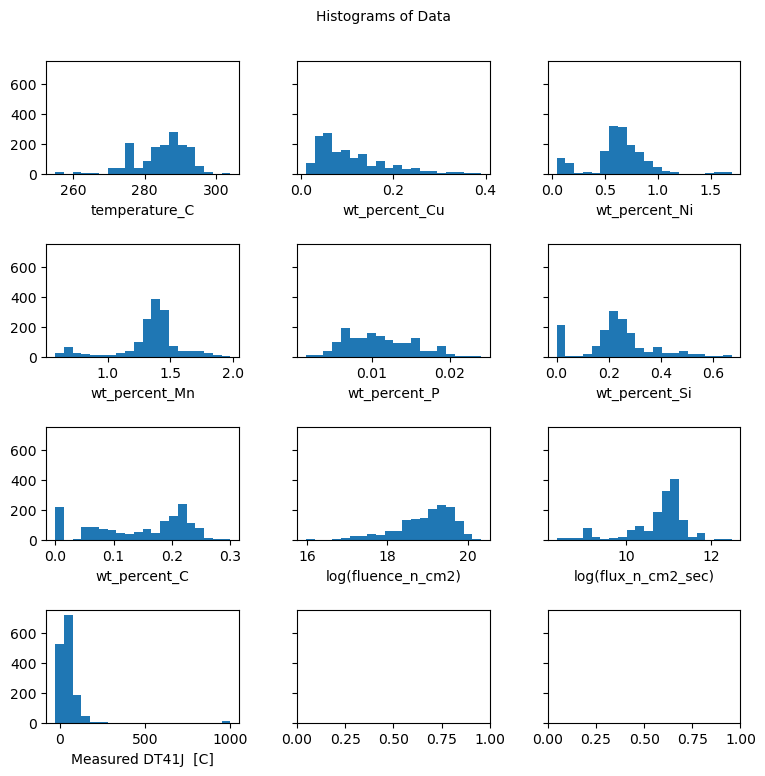

In [9]:
from scipy.stats.morestats import Std_dev
# Set plot params
n_bins = 20
figgridrow=4
figgridcol=3
fontsize=10
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
plt.rcParams["figure.figsize"] = (8,8)
fig, axs = plt.subplots(figgridrow, figgridcol, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.

fig.suptitle('Histograms of Data', fontsize=fontsize)
X_matrix = X.to_numpy()
y_matrix = y.to_numpy()
datanames=X.columns
datanames[0]
for i in range(figgridrow):
  for j in range(figgridcol):
    X_column_index=j+i*figgridcol
    if X_column_index<9:
      str=datanames[X_column_index]
      axs[i,j].hist(X[str], bins=n_bins)
      axs[i,j].set_xlabel(str, fontsize=fontsize)
    elif (X_column_index==9): # plot target y
      axs[i,j].hist(y, bins=n_bins)
      axs[i,j].set_xlabel(y.name, fontsize=fontsize)
print('Std Dev of target (want to have RMSE well below this value): %3.2f}' % (std(y)))

# Model fitting
Here is an example of how you can run multiple models and hyperparameter searches and assess each model in an automated fashion. Note that you might want to add (or change) many steps of data preprocessing, featurization, dimensional reduction, or additional model fitting.

In [10]:
# Preprocess data (e.g., scaling, PCA, etc.)
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_matrix)
X_matrix_proc = scaler.transform(X_matrix)
'''
Old section if we include steel forms.
# OneHotEncode the first column of X which are steel form types.
# This not needed in "No_Forms" versions where I removed this data.
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([("Product Form", OneHotEncoder(), [0])], remainder = 'passthrough')
X_matrix = ct.fit_transform(X_matrix)
print('Features X')
print(X_matrix)
'''

'\nOld section if we include steel forms.\n# OneHotEncode the first column of X which are steel form types.\n# This not needed in "No_Forms" versions where I removed this data.\nfrom sklearn import preprocessing\nfrom sklearn.preprocessing import OneHotEncoder\nfrom sklearn.compose import ColumnTransformer\nct = ColumnTransformer([("Product Form", OneHotEncoder(), [0])], remainder = \'passthrough\')\nX_matrix = ct.fit_transform(X_matrix)\nprint(\'Features X\')\nprint(X_matrix)\n'

In [11]:
# Get list of models and their parameters
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

model_params = {
    'linear': {
        'model': LinearRegression(),
        'params' : {}
    },
    'Lasso': {
        'model': Lasso(),
        'params' : {
            'alpha':[1E-4, 1E-3, 1E-2, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1E1, 1E2, 1E3, 1E4]
            }
    },
    'NN_MLP': {
        'model': MLPRegressor(),
        'params' : {
            'tol': [1E-1],
            'hidden_layer_sizes': [(9), (9,9), (9,9,9), (9,8,7,6)]
            }
    },
    'KNeigh': {
        'model': KNeighborsRegressor(),
        'params' : {
            'n_neighbors': [1, 2, 3, 4, 5]
            }
    },
}

In [12]:
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_error
# Run models
scores = []
scoring = ('neg_root_mean_squared_error','r2')

for model_name, mp in model_params.items():
  cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=seed)
  clf =  GridSearchCV(mp['model'], mp['params'], cv=cv, refit='neg_root_mean_squared_error', scoring=scoring, return_train_score=True, n_jobs=-1, verbose=3)
  clf.fit(X_matrix_proc, y_matrix)
  scores.append({
      'model': model_name,
      'best_score': -1*clf.best_score_,
      'best_params': clf.best_params_,
      'results': clf.cv_results_
    })
pd.set_option("display.max_rows", 6000)
pd.set_option("display.max_column", 6000)
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 17 candidates, totalling 85 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


,model,best_score,best_params
0,linear,72.480428,{}
1,Lasso,72.319619,{'alpha': 1.0}
2,NN_MLP,65.488942,"{'hidden_layer_sizes': (9, 8, 7, 6), 'tol': 0.1}"
3,KNeigh,64.295563,{'n_neighbors': 5}


# Assess fit on test data
We have two kinds of test data. We started with the full database. Then we pulled out 2 types of test data. First we pulled out all data for 66 alloys (200 points) and this is Test2. Test2 requires extrapolating to compositions not in the training data. Then we randomly pulled out abot 20% of the remaining data (370 points) for Test1. Test1 is a more traditional random leave out test set. So
* Total data = 2059 points, 624 alloys
* Test1 = 370 points, 278 alloys
* Test2 = 200 points, 66 alloys
* Final training data = 1489 points, 547 alloys.
Here we show how to load the test data and assess performance of your best model.

In [13]:
# Load test data sets
# Load dataset
TestData1 = 'RPV_Plotter_2022-10-12_simplified_TEST1_NoForms.xlsx'
TestData2 = 'RPV_Plotter_2022-10-12_simplified_TEST2_NoForms.xlsx'

# MASTML load.
target = 'Measured DT41J  [C]'
extra_columns = ['alloy']
d1 = LocalDatasets(file_path=TestData1,
                  target=target,
                  extra_columns=extra_columns,
                  testdata_columns=None,
                  as_frame=True)
d2 = LocalDatasets(file_path=TestData2,
                  target=target,
                  extra_columns=extra_columns,
                  testdata_columns=None,
                  as_frame=True)
# Load the data with the load_data() method
data_dict1 = d1.load_data()
data_dict2 = d2.load_data()

# Designate the features X, target y and and extra information X_extra data
X1 = data_dict1['X']
y1 = data_dict1['y']
X2 = data_dict2['X']
y2 = data_dict2['y']
X1_matrix = X1.to_numpy()
y1_matrix = y1.to_numpy()
X2_matrix = X2.to_numpy()
y2_matrix = y2.to_numpy()

#print(X1)
#print(X2)
print('X1 shape: ', X1.shape)
print('X2 shape: ', X2.shape)

X1 shape:  (370, 9)
X2 shape:  (200, 9)


In [14]:
# Preprocess data to match training above
X1_matrix_proc = scaler.transform(X1_matrix)
X2_matrix_proc = scaler.transform(X2_matrix)

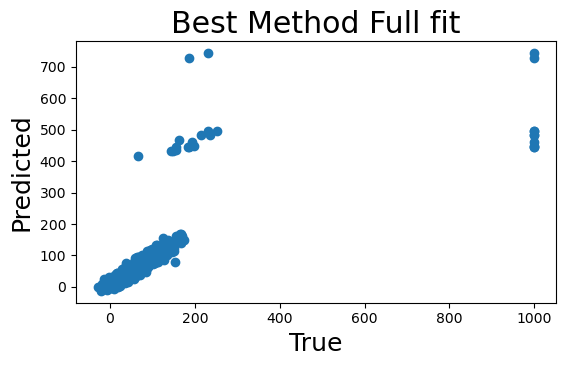

RMSE of training data full fit: 52.95


In [15]:
# Fit model to training data and show results
#fitmodel = MLPRegressor(hidden_layer_sizes= (9, 8, 7, 6),
#                        tol= 0.1,
#                 ).fit(X_matrix_proc, y_matrix)

fitmodel = KNeighborsRegressor(n_neighbors=(3)).fit(X_matrix_proc, y_matrix)

yp=fitmodel.predict(X_matrix_proc)
plt.figure(figsize=(fig_w,fig_h))
plt.scatter(y,yp,marker='o')
plt.title('Best Method Full fit')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()
print('RMSE of training data full fit: %3.2f'
      % (root_mean_squared_error(yp,y)))

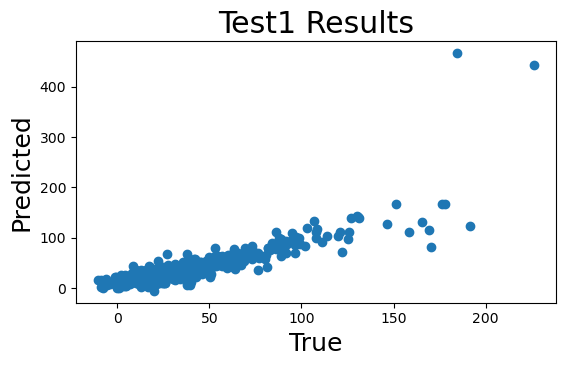

RMSE of TEST1 data prediction: 23.69


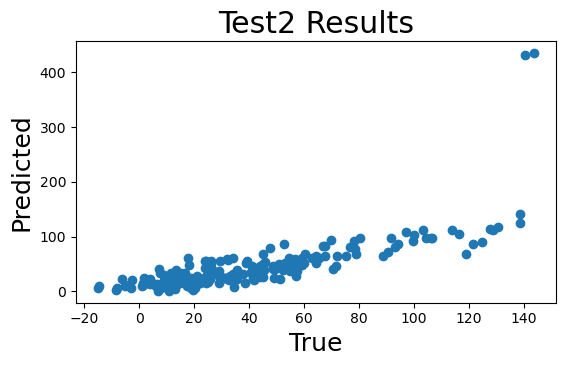

RMSE of TEST2 data prediction: 32.80
AVG RMSE of TEST1 and TEST2 data prediction: 28.24


In [16]:
# Predicte test data and show results
y1p=fitmodel.predict(X1_matrix_proc)
plt.figure(figsize=(fig_w,fig_h))
plt.scatter(y1,y1p,marker='o')
plt.title('Test1 Results')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()
print('RMSE of TEST1 data prediction: %3.2f'
      % (root_mean_squared_error(y1p,y1)))

y2p=fitmodel.predict(X2_matrix_proc)
plt.figure(figsize=(fig_w,fig_h))
plt.scatter(y2,y2p,marker='o')
plt.title('Test2 Results')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()
print('RMSE of TEST2 data prediction: %3.2f'
      % (root_mean_squared_error(y2p,y2)))
print('AVG RMSE of TEST1 and TEST2 data prediction: %3.2f'
      % ((root_mean_squared_error(y1p,y1)+root_mean_squared_error(y2p,y2))/2))

**Question 1:**  Try to find the best model for this problem. We will assess best by lowest average RMSE on the two Test datasets. You can feel free to change the training data and the model, but not the test data. Also, please do not add test data to the training data or effectively alter the training data using knowledge of the test data to create near twins to the test data.

**Question 1 Solution**

In [22]:
# Try different models

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV

# Load your dataset - You may need to adjust the file path
dataset = 'RPV_Plotter_2022-10-12_simplified_TRAIN_NoForms_ClassCompete.xlsx'
TestData1 = 'RPV_Plotter_2022-10-12_simplified_TEST1_NoForms.xlsx'
TestData2 = 'RPV_Plotter_2022-10-12_simplified_TEST2_NoForms.xlsx'

# Load and preprocess data
def load_and_preprocess_data(file_path):
    data = pd.read_excel(file_path)
    X = data.drop(columns=['Measured DT41J  [C]', 'alloy'])  # Assuming 'Measured DT41J  [C]' and 'alloy' are target and extra columns
    y = data['Measured DT41J  [C]']

    scaler = StandardScaler()
    X_matrix_proc = scaler.fit_transform(X)

    return X, y, X_matrix_proc

X, y, X_matrix_proc = load_and_preprocess_data(dataset)
X1, y1, X1_matrix_proc = load_and_preprocess_data(TestData1)
X2, y2, X2_matrix_proc = load_and_preprocess_data(TestData2)

# Define model parameters
model_params = {
    'linear': {
        'model': LinearRegression(),
        'params': {}
    },
    'lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [1E-4, 1E-3, 1E-2, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1E1, 1E2, 1E3, 1E4]
        }
    },
    'nn_mlp': {
        'model': MLPRegressor(),
        'params': {
            'tol': [1E-1],
            'hidden_layer_sizes': [(9), (9, 9), (9, 9, 9), (9, 8, 7, 6)]
        }
    },
    'kneigh': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [1, 2, 3, 4, 5]
        }
    },
    'random_forest': {
    'model': RandomForestRegressor(n_estimators=100, max_depth=10),
    'params': {}
    },
    'lasso_cv': {
    'model': LassoCV(alphas=[0.1, 1.0, 10.0]),
    'params': {}
    }
}

# Choose the best model
best_model = None
best_avg_rmse = float('inf')
seed = 42  # Set your random seed

for model_name, mp in model_params.items():
    model = mp['model']
    params = mp['params']

    # Grid search for hyperparameters
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=seed)
    clf = GridSearchCV(model, params, cv=cv, refit='neg_root_mean_squared_error', scoring='neg_root_mean_squared_error', return_train_score=True, n_jobs=-1, verbose=3)
    clf.fit(X_matrix_proc, y)

    # Predict on test data
    y1p = clf.predict(X1_matrix_proc)
    y2p = clf.predict(X2_matrix_proc)

    # Calculate RMSE on test data
    rmse1 = sqrt(mean_squared_error(y1p, y1))
    rmse2 = sqrt(mean_squared_error(y2p, y2))
    avg_rmse = (rmse1 + rmse2) / 2

    if avg_rmse < best_avg_rmse:
        best_avg_rmse = avg_rmse
        best_model = model_name

# Print the best model and its performance
print(f"Best Model: {best_model}")
print(f"Average RMSE on Test Data: {best_avg_rmse:.2f}")
print(f"RMSE1 on Test Data: {rmse1:.2f}")
print(f"RMSE2 on Test Data: {rmse2:.2f}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 17 candidates, totalling 85 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Model: lasso
Average RMSE on Test Data: 26.89
RMSE1 on Test Data: 29.35
RMSE2 on Test Data: 26.27


In [23]:
# 导入 GridSearchCV 和 RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# 定义要尝试的超参数组合
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15]
}

# 创建GridSearchCV对象
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=3)

# 在训练数据上拟合GridSearchCV
grid_search.fit(X_matrix_proc, y)

# 找到最佳超参数组合
best_model = grid_search.best_estimator_

# Predict on test data (TestData1)
y1p = best_model.predict(X1_matrix_proc)

# Calculate RMSE on test data (TestData1)
rmse1 = sqrt(mean_squared_error(y1p, y1))

# Predict on test data (TestData2)
y2p = best_model.predict(X2_matrix_proc)

# Calculate RMSE on test data (TestData2)
rmse2 = sqrt(mean_squared_error(y2p, y2))

# 打印最佳模型和其性能
print("Best Model:", best_model)
print("Average RMSE on Test Data:", (rmse1 + rmse2) / 2)
print("RMSE1 on Test Data:", rmse1)
print("RMSE2 on Test Data:", rmse2)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Model: RandomForestRegressor(max_depth=15, n_estimators=200)
Average RMSE on Test Data: 25.759311623146502
RMSE1 on Test Data: 33.74042997598035
RMSE2 on Test Data: 17.778193270312652


In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectKBest, f_regression

# Load your dataset - You may need to adjust the file path
dataset = 'RPV_Plotter_2022-10-12_simplified_TRAIN_NoForms_ClassCompete.xlsx'
TestData1 = 'RPV_Plotter_2022-10-12_simplified_TEST1_NoForms.xlsx'
TestData2 = 'RPV_Plotter_2022-10-12_simplified_TEST2_NoForms.xlsx'

# Load and preprocess data
def load_and_preprocess_data(file_path):
    data = pd.read_excel(file_path)
    X = data.drop(columns=['Measured DT41J  [C]', 'alloy'])  # Assuming 'Measured DT41J  [C]' and 'alloy' are target and extra columns
    y = data['Measured DT41J  [C]']

    scaler = StandardScaler()
    X_matrix_proc = scaler.fit_transform(X)

    return X, y, X_matrix_proc

X, y, X_matrix_proc = load_and_preprocess_data(dataset)
X1, y1, X1_matrix_proc = load_and_preprocess_data(TestData1)
X2, y2, X2_matrix_proc = load_and_preprocess_data(TestData2)

# Generate polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_matrix_proc)

# Define model parameters
model_params = {
    'linear': {
        'model': LinearRegression(),
        'params': {}
    },
    'lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [1E-4, 1E-3, 1E-2, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1E1, 1E2, 1E3, 1E4]
        }
    },
    'nn_mlp': {
        'model': MLPRegressor(),
        'params': {
            'tol': [1E-1],
            'hidden_layer_sizes': [(9), (9, 9), (9, 9, 9), (9, 8, 7, 6)]
        }
    },
    'kneigh': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [1, 2, 3, 4, 5]
        }
    },
    'random_forest': {
        'model': RandomForestRegressor(n_estimators=100, max_depth=10),
        'params': {}
    },
    'lasso_cv': {
        'model': LassoCV(alphas=[0.1, 1.0, 10.0]),
        'params': {}
    }
}

# Choose the best model
best_model = None
best_avg_rmse = float('inf')
seed = 42  # Set your random seed

for model_name, mp in model_params.items():
    model = mp['model']
    params = mp['params']

    # Grid search for hyperparameters
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=seed)
    clf = GridSearchCV(model, params, cv=cv, refit='neg_root_mean_squared_error', scoring='neg_root_mean_squared_error', return_train_score=True, n_jobs=-1, verbose=3)
    clf.fit(X_poly, y)  # Use X_poly with polynomial features

    # Predict on test data
    y1p = clf.predict(poly.transform(X1_matrix_proc))
    y2p = clf.predict(poly.transform(X2_matrix_proc))

    # Calculate RMSE on test data
    rmse1 = sqrt(mean_squared_error(y1p, y1))
    rmse2 = sqrt(mean_squared_error(y2p, y2))
    avg_rmse = (rmse1 + rmse2) / 2

    if avg_rmse < best_avg_rmse:
        best_avg_rmse = avg_rmse
        best_model = model_name

# Print the best model and its performance
print(f"Best Model: {best_model}")
print(f"Average RMSE on Test Data: {best_avg_rmse:.2f}")
print(f"RMSE1 on Test Data: {rmse1:.2f}")
print(f"RMSE2 on Test Data: {rmse2:.2f}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 17 candidates, totalling 85 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Model: kneigh
Average RMSE on Test Data: 25.61
RMSE1 on Test Data: 32.50
RMSE2 on Test Data: 28.20
